In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_csv("Eartquakes-1990-2023.csv")
data['date'] = pd.to_datetime(data['date'], format='ISO8601', errors='coerce')
data.set_index('date', inplace=True)

In [3]:
data.describe

<bound method NDFrame.describe of                                            time  \
date                                              
1990-01-01 00:22:33.990000+00:00   631153353990   
1990-01-01 00:24:51.210000+00:00   631153491210   
1990-01-01 00:34:43.450000+00:00   631154083450   
1990-01-01 00:58:32.130000+00:00   631155512130   
1990-01-01 01:03:44.490000+00:00   631155824490   
...                                         ...   
2023-07-29 10:34:11.941000+00:00  1690626851941   
2023-07-29 10:36:15.715000+00:00  1690626975715   
2023-07-29 10:40:15.940000+00:00  1690627215940   
2023-07-29 10:55:46.040000+00:00  1690628146040   
2023-07-29 11:08:57.884000+00:00  1690628937884   

                                                                     place  \
date                                                                         
1990-01-01 00:22:33.990000+00:00         12 km NNW of Meadow Lakes, Alaska   
1990-01-01 00:24:51.210000+00:00                14 km S of Volcano, 

In [4]:
def drop_outliers(data, columns):
    for item in columns:
        q1 = data[item].quantile(0.10)
        q3 = data[item].quantile(0.90)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr

        upper_array = data.index[data[item] >= upper].tolist()
        lower_array = data.index[data[item] <= lower].tolist()

        data.drop(index=upper_array, inplace=True)
        data.drop(index=lower_array, inplace=True)

    return data

data = drop_outliers(data, data[["longitude", "latitude", "depth","magnitudo"]])

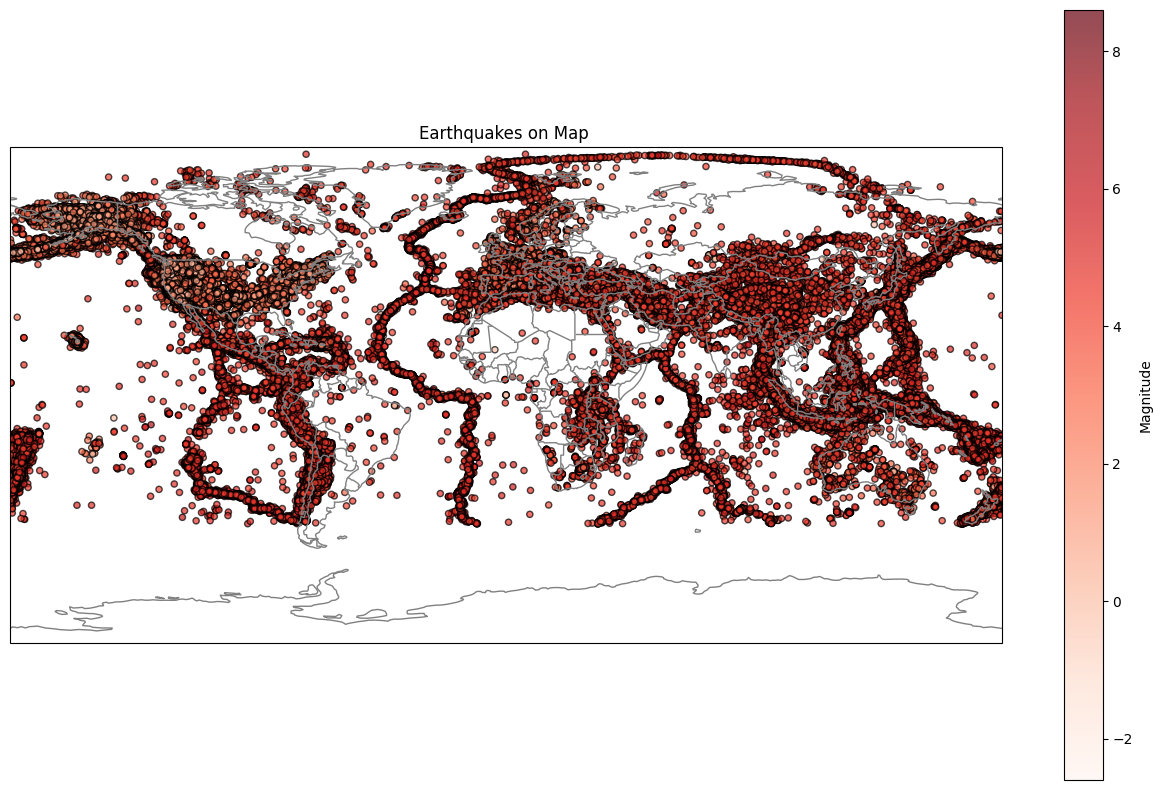

In [5]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def draw_earthquakes_on_map(df, mask=None, mask_title='', x='longitude', y='latitude', color_col='magnitudo', full_map=True):
    if mask is not None:
        df = df[mask]
    
    fig, ax = plt.subplots(figsize=(16, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    if full_map:
        ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
    
    ax.add_feature(cfeature.COASTLINE, linestyle='-', linewidth=1, edgecolor='grey')
    ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=1, edgecolor='grey')
    
    scatter = ax.scatter(df[x], df[y], c=df[color_col], cmap='Reds', alpha=0.7, s=20, edgecolors='k')
    
    plt.colorbar(scatter, ax=ax, label='Magnitude')
    
    plt.title(f'Earthquakes on Map {mask_title}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Call the function
draw_earthquakes_on_map(data)


In [6]:
print(data.info())
print(data.head())
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3359399 entries, 1990-01-01 00:22:33.990000+00:00 to 2023-07-29 10:55:46.040000+00:00
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   time          int64  
 1   place         object 
 2   status        object 
 3   tsunami       int64  
 4   significance  int64  
 5   data_type     object 
 6   magnitudo     float64
 7   state         object 
 8   longitude     float64
 9   latitude      float64
 10  depth         float64
dtypes: float64(4), int64(3), object(4)
memory usage: 307.6+ MB
None
                                          time  \
date                                             
1990-01-01 00:22:33.990000+00:00  631153353990   
1990-01-01 00:24:51.210000+00:00  631153491210   
1990-01-01 00:34:43.450000+00:00  631154083450   
1990-01-01 00:58:32.130000+00:00  631155512130   
1990-01-01 01:03:44.490000+00:00  631155824490   

                                                         

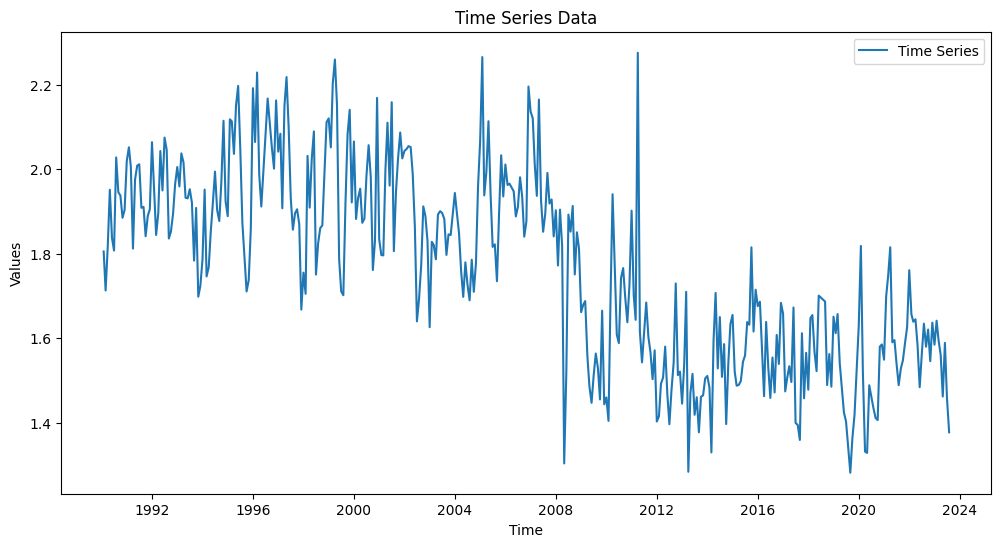

In [7]:
data = data['magnitudo'].resample('M').mean().dropna()
plt.figure(figsize=(12, 6))
plt.plot(data, label="Time Series")
plt.xlabel("Time")
plt.ylabel("Values")
plt.title("Time Series Data")
plt.legend()
plt.show()

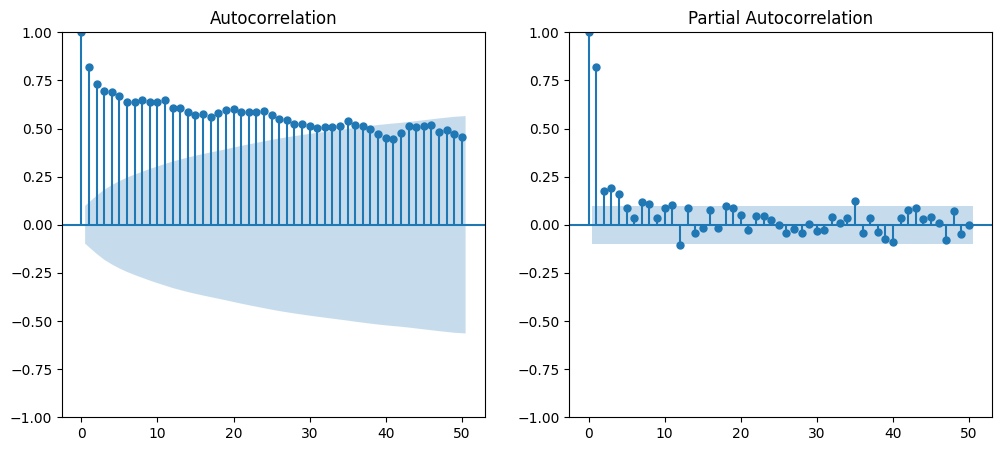

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(data, ax=axes[0], lags=50)
plot_pacf(data, ax=axes[1], lags=50)
plt.show()

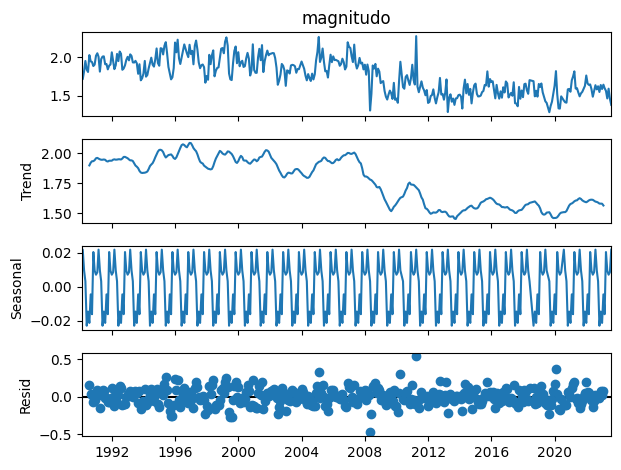

In [9]:
result = seasonal_decompose(data, model='additive', period=12)
result.plot()
plt.show()

In [10]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

X, y = [], []
sequence_length = 30
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i+sequence_length])
    y.append(data_scaled[i+sequence_length])
X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

gru_model = Sequential([
    GRU(100, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    GRU(100, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

gru_forecast = gru_model.predict(X_test[-30:])
gru_forecast = scaler.inverse_transform(gru_forecast)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0908 - val_loss: 0.0289
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0276 - val_loss: 0.0124
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0253 - val_loss: 0.0199
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0233 - val_loss: 0.0130
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0248 - val_loss: 0.0158
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0242 - val_loss: 0.0123
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0219 - val_loss: 0.0155
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0222 - val_loss: 0.0126
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0209 - val_loss: 0.0135
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0214 - val_loss: 0.0137
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0219 - val_loss: 0.0135
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

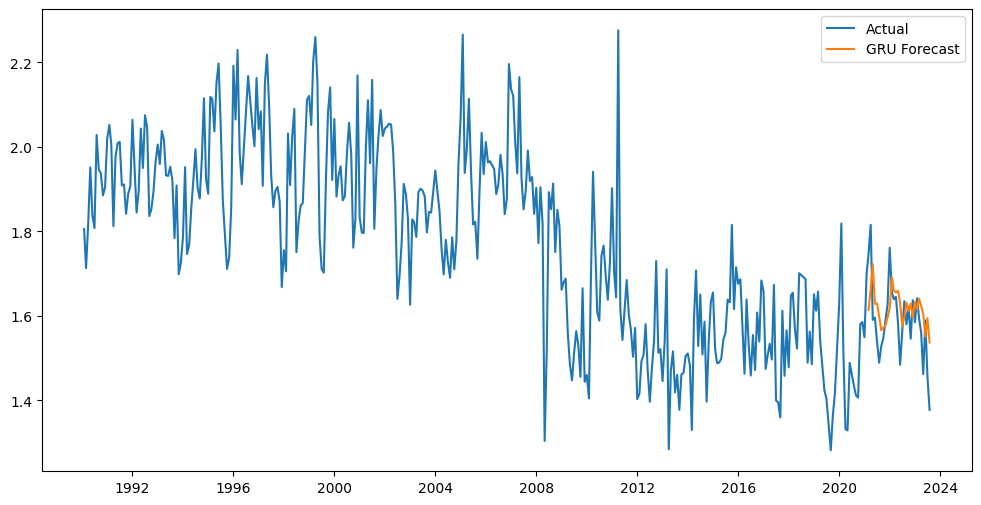

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label="Actual")
plt.plot(data.index[-30:], gru_forecast, label="GRU Forecast")
plt.legend()
plt.show()

In [12]:
# Predict on the test set
gru_predictions = gru_model.predict(X_test)
gru_predictions = scaler.inverse_transform(gru_predictions)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate error metrics
mae = mean_absolute_error(y_test_actual, gru_predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, gru_predictions))
mape = np.mean(np.abs((y_test_actual - gru_predictions) / y_test_actual)) * 100
accuracy = 100 - mape  # Accuracy as (100 - MAPE)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Forecast Accuracy: {accuracy:.2f}%")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 
Mean Absolute Error (MAE): 0.0866
Root Mean Squared Error (RMSE): 0.1049
Mean Absolute Percentage Error (MAPE): 5.66%
Forecast Accuracy: 94.34%


In [13]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.values.reshape(-1, 1))

X, y = [], []
sequence_length = 30
for i in range(len(data_scaled) - sequence_length):
    X.append(data_scaled[i:i+sequence_length])
    y.append(data_scaled[i+sequence_length])
X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.3),
    LSTM(100, return_sequences=False),
    Dropout(0.3),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

lstm_forecast = lstm_model.predict(X_test[-30:])
lstm_forecast = scaler.inverse_transform(lstm_forecast)

# Evaluate the model
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_predicted = scaler.inverse_transform(lstm_model.predict(X_test))

mae = mean_absolute_error(y_test_actual, y_test_predicted)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_predicted))
mape = np.mean(np.abs((y_test_actual - y_test_predicted) / y_test_actual)) * 100
accuracy = 100 - mape  # Accuracy as (100 - MAPE)

# Print results
print(f"LSTM Model Accuracy:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Forecast Accuracy: {accuracy:.2f}%")


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 0.1156 - val_loss: 0.0135
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0400 - val_loss: 0.0166
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0305 - val_loss: 0.0149
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0265 - val_loss: 0.0163
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0240 - val_loss: 0.0183
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0248 - val_loss: 0.0152
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0246 - val_loss: 0.0156
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0245 - val_loss: 0.0157
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0245 - val_loss: 0.0140
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0245 - val_loss: 0.0155
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0233 - val_loss: 0.0139
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

In [18]:
arima_data = data.resample('M').mean().dropna()
model_arima = ARIMA(arima_data, order=(5,1,0))
model_arima_fit = model_arima.fit()
arima_forecast = model_arima_fit.forecast(steps=30)
arima_forecast = arima_forecast[-30:]
arima_forecast = arima_forecast.to_numpy() 

mae_arima = mean_absolute_error(y_test_actual[-30:], arima_forecast)
rmse_arima = np.sqrt(mean_squared_error(y_test_actual[-30:], arima_forecast))
mape_arima = np.mean(np.abs((y_test_actual[-30:] - arima_forecast) / y_test_actual[-30:])) * 100
accuracy_arima = 100 - mape_arima

print(f"ARIMA Model Accuracy:")
print(f"Mean Absolute Error (MAE): {mae_arima:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_arima:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_arima:.2f}%")
print(f"Forecast Accuracy: {accuracy_arima:.2f}%")

ARIMA Model Accuracy:
Mean Absolute Error (MAE): 0.1425
Root Mean Squared Error (RMSE): 0.1635
Mean Absolute Percentage Error (MAPE): 8.73%
Forecast Accuracy: 91.27%


In [20]:
prophet_df = arima_data.reset_index()
prophet_df.columns = ['ds', 'y']
prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)

prophet = Prophet()
prophet.fit(prophet_df)

future = prophet.make_future_dataframe(periods=30, freq='M')

forecast = prophet.predict(future)

prophet_forecast = forecast[['ds', 'yhat']].set_index('ds')
prophet_predictions = prophet_forecast[-30:]['yhat'].values
prophet_predictions = prophet_predictions[-30:]

mae_prophet = mean_absolute_error(y_test_actual[-30:], prophet_predictions)
rmse_prophet = np.sqrt(mean_squared_error(y_test_actual[-30:], prophet_predictions))
mape_prophet = np.mean(np.abs((y_test_actual[-30:] - prophet_predictions) / y_test_actual[-30:])) * 100
accuracy_prophet = 100 - mape_prophet

print(f"Prophet Model Accuracy:")
print(f"Mean Absolute Error (MAE): {mae_prophet:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse_prophet:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_prophet:.2f}%")
print(f"Forecast Accuracy: {accuracy_prophet:.2f}%")

21:27:50 - cmdstanpy - INFO - Chain [1] start processing
21:27:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet Model Accuracy:
Mean Absolute Error (MAE): 0.0923
Root Mean Squared Error (RMSE): 0.1145
Mean Absolute Percentage Error (MAPE): 5.05%
Forecast Accuracy: 94.95%


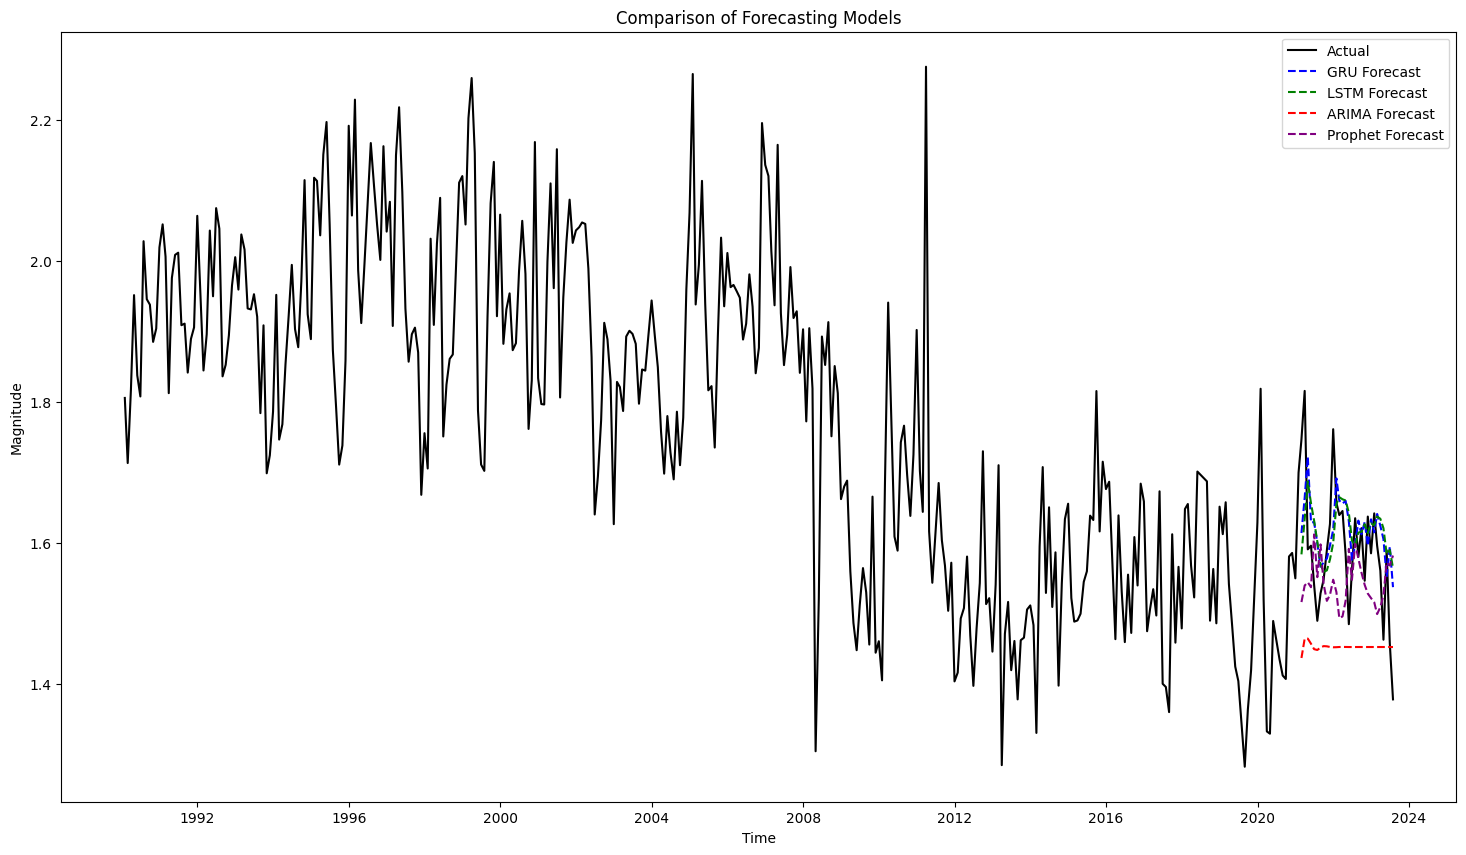

In [21]:
plt.figure(figsize=(18, 10))
plt.plot(data.index, data, label="Actual", color='black')
plt.plot(data.index[-30:], gru_forecast, label="GRU Forecast", linestyle="dashed", color='blue')
plt.plot(data.index[-30:], lstm_forecast, label="LSTM Forecast", linestyle="dashed", color='green')
plt.plot(data.index[-30:], arima_forecast, label="ARIMA Forecast", linestyle="dashed", color='red')
plt.plot(data.index[-30:], prophet_predictions, label="Prophet Forecast", linestyle="dashed", color='purple')

plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.title("Comparison of Forecasting Models")
plt.legend()
plt.show()

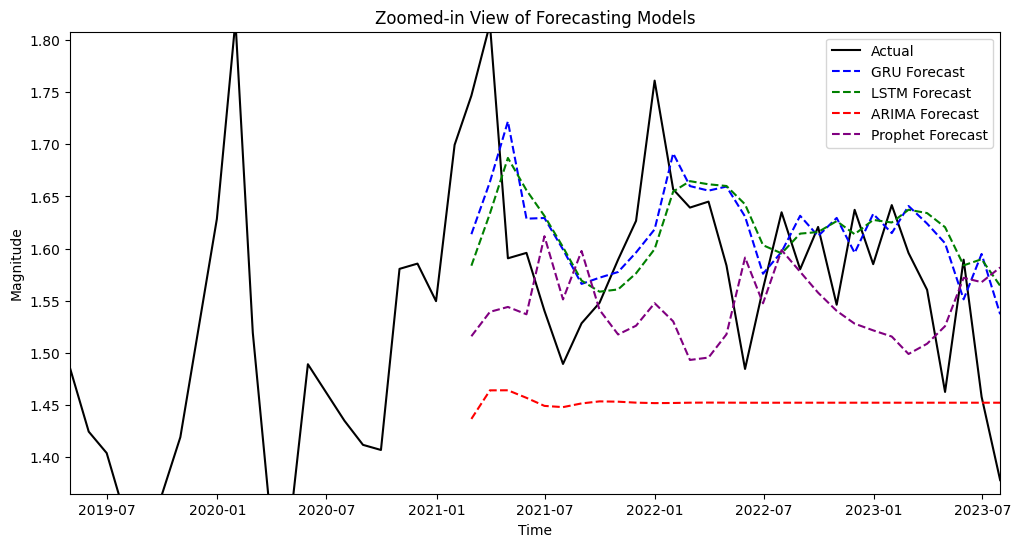

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label="Actual", color='black')
plt.plot(data.index[-30:], gru_forecast, label="GRU Forecast", linestyle="dashed", color='blue')
plt.plot(data.index[-30:], lstm_forecast, label="LSTM Forecast", linestyle="dashed", color='green')
plt.plot(data.index[-30:], arima_forecast, label="ARIMA Forecast", linestyle="dashed", color='red')
plt.plot(data.index[-30:], prophet_predictions, label="Prophet Forecast", linestyle="dashed", color='purple')

# Zoom in on the forecasted region
plt.xlim(data.index[-50], data.index[-1])  # Adjust to focus on recent data
plt.ylim(min(gru_forecast.min(), lstm_forecast.min(), arima_forecast.min(), prophet_predictions.min()) * 0.95, 
         max(gru_forecast.max(), lstm_forecast.max(), arima_forecast.max(), prophet_predictions.max()) * 1.05)

plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.title("Zoomed-in View of Forecasting Models")
plt.legend()
plt.show()